<a href="https://colab.research.google.com/github/tsido/lda-thesis/blob/main/topic_extraction/lda/LDA_create_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for evaluation of LDA topic model

Creates a LDA topic model with 46 distinct topics with Octis.

Use Octis for optimizing the hyperparameters. Hyperparameters that are
explored are alpha and eta and we optimize for coherence.

Gensim LDA model is persisted to disk for further evaluation.

The evaluation and further investigation of the LDA model is also done in this Notebook.


In [ ]:
# Fetch the app store data
!mkdir data
!wget --no-check-certificate --output-document=data/enriched_data.csv 'https://raw.githubusercontent.com/tsido/lda-thesis/main/data/enriched_data.csv'
!wget --no-check-certificate --output-document=data/optimization_results.csv 'https://raw.githubusercontent.com/tsido/lda-thesis/main/topic_extraction/lda/optimization_results.csv'

!mkdir data/octis


mkdir: cannot create directory ‘data’: File exists
--2023-12-28 18:09:56--  https://raw.githubusercontent.com/tsido/lda-thesis/main/data/enriched_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31862266 (30M) [text/plain]
Saving to: ‘data/enriched_data.csv’

data/enriched_data. 100%[===================>]  30.39M  --.-KB/s    in 0.1s    

2023-12-28 18:09:56 (314 MB/s) - ‘data/enriched_data.csv’ saved [31862266/31862266]

--2023-12-28 18:09:56--  https://raw.githubusercontent.com/tsido/lda-thesis/main/topic_extraction/lda/optimization_results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:

In [ ]:
!pip install octis


In [ ]:
import inspect
import pickle

import pandas as pd
import numpy as np

from octis.models.LDA import LDA
from octis.dataset.dataset import Dataset
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel



In [63]:
# Configuration options

# Run or skip optimization step, skip if the optimization data is already available
RUN_OPTIMIZER=True


num_topics = 46 # Number of topics to generate
top_k = 5      # Top words to inspect in metrics


In [85]:

# read in the document data
df = pd.read_csv('data/enriched_data.csv')

descriptions = df['PreprocessedDescription'].str.split()


In [86]:
# Prepare custom dataset in a format described
# here: https://github.com/MIND-Lab/OCTIS/tree/master/preprocessed_datasets/sample_dataset

df['split'] = np.random.choice(['train', 'test', 'val'], size=len(df), p=[0.8, 0.1, 0.1])
df['split'] = pd.Categorical(df['split'], categories=['train', 'val', 'test'], ordered=True)
corpus_df = df[['PreprocessedDescription', 'split']].sort_values(by='split')

corpus_df[['PreprocessedDescription', 'split']].to_csv('data/octis/corpus.tsv', sep='\t', header=False, index=False)

# Create the vocabulary.txt file using Gensim and keep 2000 most relevant words only
dictionary = Dictionary(descriptions)

# remove tokens that don't occur in at least 3 documents
# and occur in over 50% of docs
dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=2000)

# create vocabulary.txt file by getting unique words from the dictionary
with open("data/octis/vocabulary.txt", "w") as f:
    for (k,word) in dictionary.items():
      f.write(word +'\n')


In [67]:
# Load the dataset
octis_dataset = Dataset()
octis_dataset.load_custom_dataset_from_folder('data/octis');


In [68]:
# Perform gridsearch using sklearn over the different
# combinations os Gensis parameters
# We can't use the OCTIS optimizer since it doesn't provide
# grid search over the categorical paramters we want (or at
# least I don't know how to use it for that)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

static_hyperparameters = {
    'num_topics': num_topics,
    'passes': 5, # 5
    'chunksize': 2000,
    'iterations': 50,  # 500
    'random_state': 0
    }

if (RUN_OPTIMIZER):

  search_grid = {

      'alpha': ['asymmetric', 'auto', 'symmetric'],
      'eta': ['auto', 'symmetric', 0.5, 1]
  }

  npmi = Coherence(topk=top_k, texts=octis_dataset.get_corpus(), measure='c_npmi')
  diversity = TopicDiversity(topk=top_k)

  param_search_df = pd.DataFrame(columns = ['alpha', 'eta', 'npmi', 'diversity'])

  for params in ParameterGrid(search_grid):
      model = LDA()

      model.hyperparameters.update(static_hyperparameters)
      model.set_hyperparameters(**params)

      model_output = model.train_model(octis_dataset, top_words=top_k)

      coherence_score = npmi.score(model_output)
      diversity_score = diversity.score(model_output)

      param_search_df.loc[len(param_search_df)] = {
          'alpha': model.hyperparameters['alpha'],
          'eta': model.hyperparameters['eta'],
          'npmi': coherence_score,
          'diversity': diversity_score
      };
      print(param_search_df)

  param_search_df.to_csv('data/optimization_results.csv')
else:
  print('Skipping optimizer. Use already found hyperparameters')


        alpha   eta      npmi  diversity
0  asymmetric  auto  0.073565    0.83913
        alpha        eta      npmi  diversity
0  asymmetric       auto  0.073565    0.83913
1  asymmetric  symmetric  0.073565    0.83913
        alpha        eta      npmi  diversity
0  asymmetric       auto  0.073565   0.839130
1  asymmetric  symmetric  0.073565   0.839130
2  asymmetric        0.5  0.282157   0.947826
        alpha        eta      npmi  diversity
0  asymmetric       auto  0.073565   0.839130
1  asymmetric  symmetric  0.073565   0.839130
2  asymmetric        0.5  0.282157   0.947826
3  asymmetric          1  0.287125   0.865217
        alpha        eta      npmi  diversity
0  asymmetric       auto  0.073565   0.839130
1  asymmetric  symmetric  0.073565   0.839130
2  asymmetric        0.5  0.282157   0.947826
3  asymmetric          1  0.287125   0.865217
4        auto       auto  0.069581   0.839130
        alpha        eta      npmi  diversity
0  asymmetric       auto  0.073565   0.83913

In [69]:
optimization_df = pd.read_csv('data/optimization_results.csv')
optimization_df

,Unnamed: 0,alpha,eta,npmi,diversity
0,0,asymmetric,auto,0.073565,0.839130
1,1,asymmetric,symmetric,0.073565,0.839130
2,2,asymmetric,0.5,0.282157,0.947826
3,3,asymmetric,1,0.287125,0.865217
4,4,auto,auto,0.069581,0.839130
5,5,auto,symmetric,0.069581,0.839130
6,6,auto,0.5,0.215741,0.947826
7,7,auto,1,0.308897,0.917391
8,8,symmetric,auto,0.064768,0.830435
9,9,symmetric,symmetric,0.064768,0.830435


In [70]:

# Create the final LDA model using alpha and eta parameters
# with highest coherence
static_hyperparameters['alpha'] = 'symmetric'
static_hyperparameters['eta'] = 1.0
#static_hyperparameters['eta'] = 'symmetric'


model = LDA()
model.hyperparameters.update(static_hyperparameters)
model_output = model.train_model(octis_dataset)


In [71]:
diversity = TopicDiversity(topk=top_k) # Initialize metric
print("Diversity: ", diversity.score(model_output))


Diversity:  0.9130434782608695


In [72]:
descs = df['PreprocessedDescription']
texts = [doc.split(' ') for doc in descs]

coherence = Coherence(topk=top_k, texts=texts)
print("Coherence: ", coherence.score(model_output))

Coherence:  0.31001290845904544


In [73]:
# print topics
gensim_lda = model.trained_model;
gensim_lda.print_topics(num_topics=num_topics, num_words=top_k)


[(0,
  '0.009*"patti" + 0.005*"teen" + 0.002*"octro" + 0.001*"href" + 0.001*"gullak"'),
 (1,
  '0.006*"les" + 0.003*"pour" + 0.003*"jeu" + 0.003*"vous" + 0.002*"tarot"'),
 (2,
  '0.000*"duke" + 0.000*"nukem" + 0.000*"për" + 0.000*"dhe" + 0.000*"fëmijët"'),
 (3,
  '0.000*"各コース上に存在するチェックポイントを順に通過し、ゴールへ！" + 0.000*"mkii" + 0.000*"スピットファイア" + 0.000*"利用可能機" + 0.000*"上記以外も今後も様々なコース・機体を追加予定"'),
 (4, '0.002*"med" + 0.001*"kan" + 0.001*"som" + 0.001*"och" + 0.001*"til"'),
 (5,
  '0.000*"jass" + 0.000*"kynaps" + 0.000*"proposing" + 0.000*"opting" + 0.000*"stôck"'),
 (6,
  '0.000*"yang" + 0.000*"sabertooth" + 0.000*"gambar" + 0.000*"dan" + 0.000*"untuk"'),
 (7,
  '0.000*"＊如果你不理他，他还会打哈欠，伸懒腰。" + 0.000*"快乐的音符精灵来了！" + 0.000*"＊抚摸他的不同部位，每个部位都给你惊喜的回应！" + 0.000*"titi的精灵魔法：" + 0.000*"＊随音乐左右摇摆，或许还会有转身转圈，动作堪比专业舞蹈演员！"'),
 (8,
  '0.000*"tsuccomi" + 0.000*"varianta" + 0.000*"hra" + 0.000*"hráči" + 0.000*"přístroji"'),
 (9,
  '0.001*"trademarks" + 0.001*"sega" + 0.001*"logo" + 0.001*"reserved" + 0.001*"rights"')

In [83]:
df['PreprocessedDescription'].str.contains('jass').sum()


8

In [74]:
#store the topic model to disk
!mkdir data/gensim
gensim_lda.save('data/gensim/gensim_lda.model')


mkdir: cannot create directory ‘data/gensim’: File exists


In [75]:
topic_strings = []
topic_probabilities = []
n_top_topics = 3

corpus = [dictionary.doc2bow(desc) for desc in descriptions]


# turn the topics into actual words
for doc in corpus:
    doc_topic_strings = []
    doc_topic_probabilities = []

    doc_topics = gensim_lda.get_document_topics(doc)
    # sort topics by prob and get the top 3 topics for each doc
    doc_topics.sort(key=lambda x: x[1], reverse=True)

    for i in range(n_top_topics):
        topic_id = doc_topics[i][0] if i < len(doc_topics) else -1

        if topic_id == -1:
            doc_topic_strings.append(' ')
            doc_topic_probabilities.append(0)
            continue

        words = [w[0] for w in gensim_lda.show_topic(topic_id, topn=5)]
        doc_topic_strings.append(' '.join(words))
        doc_topic_probabilities.append(doc_topics[i][1])

    topic_strings.append(doc_topic_strings)
    topic_probabilities.append(doc_topic_probabilities)


In [87]:
# get top 3 scoring topics and create a data frame that contains the topics and the original document text
topic_df = pd.concat([df['App_Name'], df['PreprocessedDescription'], pd.DataFrame(topic_strings), pd.DataFrame(topic_probabilities)], axis=1)
topic_df.columns = ['AppName', 'TrimmedDescription', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_1_p', 'Topic_2_p', 'Topic_3_p']


In [94]:
topic_df

,AppName,TrimmedDescription,Topic_1,Topic_2,Topic_3,Topic_1_p,Topic_2_p,Topic_3_p
0,AAA³ Little Ponies & Unicorns,welcome land fairies puzzle game toddlers kids...,game app fun new games,,,0.860195,0.000000,0.000000
1,GA1: An Assassin in Orlandes,interactive fantasy adventure book game rpg ga...,game app fun new games,game play games free fun,und die der das für,0.903590,0.058552,0.029956
2,Baby Games App (by HAPPYTOUCH®),plenty press touch explore children ages happy...,game app fun new games,game play games free fun,,0.899705,0.085512,0.000000
3,Hadean Lands,winner xyzzy interactive fiction awards best p...,game app fun new games,game play games free fun,,0.796404,0.190226,0.000000
4,Pango and friends,discover unpublished pango stories interactive...,game app fun new games,game play games free fun,,0.766561,0.222117,0.000000
...,...,...,...,...,...,...,...,...
12896,Touchdown Hero: New Season,new season finally field outmanoeuvre defender...,game app fun new games,game play games free fun,,0.636994,0.316930,0.000000
12897,Hidden Objects USA Time Object,vacation usa explore beautiful travel spots me...,game app fun new games,game play games free fun,car racing cars dracula atlantis,0.603027,0.374195,0.014285
12898,Slots! Golden Cherry,number casino slot machine real play free fore...,game play games free fun,game app fun new games,,0.506437,0.476328,0.000000
12899,XAirports,xairports utility app allows owner popular fli...,game app fun new games,car racing cars dracula atlantis,game play games free fun,0.825927,0.094838,0.068375


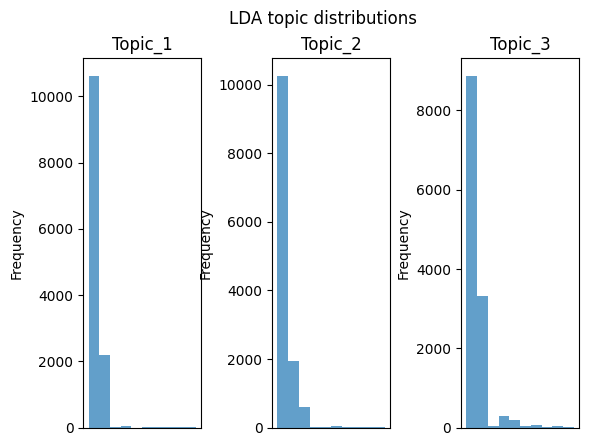

In [89]:
import matplotlib.pyplot as plt

# The topic distribution of this model is highly skewed

columns = ['Topic_1', 'Topic_2','Topic_3']

fig, ax = plt.subplots(nrows=1, ncols=3)
for i, column in enumerate(columns):
    ax[i].hist(topic_df[column], alpha=0.7)
    ax[i].set_title(column)
    ax[i].set_ylabel('Frequency')
    ax[i].get_xaxis().set_visible(False)

plt.subplots_adjust(wspace=0.6)
plt.suptitle('LDA topic distributions')
plt.show()



In [95]:
# The resulting topics from OCTIS seem quite nonsensical so this is an alternative
# attempt to see how the topics created directly with Gensim look like.

# The results are way more sensible. Interestingly the coherence score for these
# results is almost half lower than the one generated by OCTIS. It is unclear
# what causes this difference.


descriptions = df['PreprocessedDescription'].str.split()
corpus = [dictionary.doc2bow(desc) for desc in descriptions]
# Train the model on the corpus.
lda = LdaModel(corpus, num_topics=num_topics, eta=static_hyperparameters['eta'],
               alpha=static_hyperparameters['alpha'],
               iterations=50, random_state=0, passes=5, chunksize=2000, id2word=dictionary)

lda.print_topics(num_topics=num_topics, num_words=top_k)

[(0,
  '0.051*"chess" + 0.031*"pieces" + 0.028*"board" + 0.020*"moves" + 0.017*"piece"'),
 (1,
  '0.035*"games" + 0.034*"big" + 0.029*"fish" + 0.025*"enjoy" + 0.019*"discover"'),
 (2,
  '0.062*"app" + 0.035*"privacy" + 0.026*"policy" + 0.020*"use" + 0.020*"terms"'),
 (3,
  '0.029*"ice" + 0.029*"fashion" + 0.021*"star" + 0.016*"world" + 0.015*"choose"'),
 (4,
  '0.050*"box" + 0.047*"run" + 0.045*"boxes" + 0.025*"timer" + 0.013*"dig"'),
 (5,
  '0.022*"fun" + 0.017*"baby" + 0.017*"cute" + 0.014*"like" + 0.014*"love"'),
 (6,
  '0.047*"players" + 0.036*"player" + 0.024*"friends" + 0.020*"online" + 0.020*"multiplayer"'),
 (7,
  '0.027*"app" + 0.027*"stage" + 0.025*"stages" + 0.021*"use" + 0.019*"feature"'),
 (8,
  '0.034*"war" + 0.027*"strategy" + 0.021*"campaign" + 0.018*"battle" + 0.016*"battles"'),
 (9,
  '0.147*"train" + 0.038*"dragon" + 0.038*"trains" + 0.033*"bridge" + 0.029*"monkey"'),
 (10,
  '0.069*"iphone" + 0.066*"ipad" + 0.032*"touch" + 0.031*"ipod" + 0.015*"dice"'),
 (11,
  '0.0

In [103]:
gensim_topic_strings = []
gensim_topic_probabilities = []
n_top_topics = 3

corpus = [dictionary.doc2bow(desc) for desc in descriptions]


# turn the topics into actual words
for doc in corpus:
    doc_topic_strings = []
    doc_topic_probabilities = []

    doc_topics = lda.get_document_topics(doc)
    # sort topics by prob and get the top 3 topics for each doc
    doc_topics.sort(key=lambda x: x[1], reverse=True)

    for i in range(n_top_topics):
        topic_id = doc_topics[i][0] if i < len(doc_topics) else -1

        if topic_id == -1:
            doc_topic_strings.append(' ')
            doc_topic_probabilities.append(0)
            continue

        words = [w[0] for w in lda.show_topic(topic_id, topn=5)]
        doc_topic_strings.append(' '.join(words))
        doc_topic_probabilities.append(doc_topics[i][1])

    gensim_topic_strings.append(doc_topic_strings)
    gensim_topic_probabilities.append(doc_topic_probabilities)


In [104]:
# get top 3 scoring topics and create a data frame that contains the topics and the original document text
gensim_topic_df = pd.concat([df['App_Name'], df['PreprocessedDescription'], pd.DataFrame(gensim_topic_strings), pd.DataFrame(gensim_topic_probabilities)], axis=1)
gensim_topic_df.columns = ['AppName', 'TrimmedDescription', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_1_p', 'Topic_2_p', 'Topic_3_p']


In [105]:
gensim_topic_df

,AppName,TrimmedDescription,Topic_1,Topic_2,Topic_3,Topic_1_p,Topic_2_p,Topic_3_p
0,AAA³ Little Ponies & Unicorns,welcome land fairies puzzle game toddlers kids...,kids children fun app learn,puzzle puzzles sudoku solve levels,monsters monster land rush crush,0.509538,0.194557,0.162352
1,GA1: An Assassin in Orlandes,interactive fantasy adventure book game rpg ga...,adventure story island world new,iphone ipad touch ipod dice,world new unique create rpg,0.422475,0.146460,0.141635
2,Baby Games App (by HAPPYTOUCH®),plenty press touch explore children ages happy...,kids children fun app learn,music sound effects fun sounds,,0.803769,0.181513,0.000000
3,Hadean Lands,winner xyzzy interactive fiction awards best p...,games gameplay com app best,adventure story island world new,puzzle puzzles sudoku solve levels,0.500188,0.357172,0.074253
4,Pango and friends,discover unpublished pango stories interactive...,kids children fun app learn,app pieces jigsaw pictures coloring,adventure story island world new,0.377090,0.183973,0.170504
...,...,...,...,...,...,...,...,...
12896,Touchdown Hero: New Season,new season finally field outmanoeuvre defender...,players player friends online multiplayer,ball screen tap jump right,friends fun challenge score time,0.507597,0.303169,0.144716
12897,Hidden Objects USA Time Object,vacation usa explore beautiful travel spots me...,hidden objects object games adventure,puzzle puzzles sudoku solve levels,word words letters letter search,0.464907,0.226337,0.153334
12898,Slots! Golden Cherry,number casino slot machine real play free fore...,free casino games win slots,,,0.982530,0.000000,0.000000
12899,XAirports,xairports utility app allows owner popular fli...,simulator flight realistic fly plane,iphone ipad touch ipod dice,ice fashion star world choose,0.731626,0.166811,0.057133


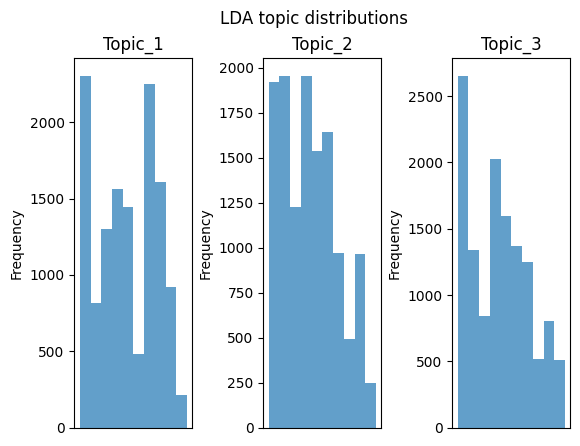

In [106]:
import matplotlib.pyplot as plt

# The topic distribution of this model is highly skewed

columns = ['Topic_1', 'Topic_2','Topic_3']

fig, ax = plt.subplots(nrows=1, ncols=3)
for i, column in enumerate(columns):
    ax[i].hist(gensim_topic_df[column], alpha=0.7)
    ax[i].set_title(column)
    ax[i].set_ylabel('Frequency')
    ax[i].get_xaxis().set_visible(False)

plt.subplots_adjust(wspace=0.6)
plt.suptitle('LDA topic distributions')
plt.show()


In [141]:
from gensim.models.coherencemodel import CoherenceModel

corpus_texts = df['PreprocessedDescription'].str.split().values
cm = CoherenceModel(model=lda, dictionary=dictionary, texts=corpus_texts, coherence='c_npmi', topn=5)
print("Coherence for the direct Gensim LDA", cm.get_coherence())

cm = CoherenceModel(model=gensim_lda, texts=corpus_texts, coherence='c_npmi', topn=5)
print("Coherence for the OCTIS LDA ", cm.get_coherence())



Coherence for the direct Gensim LDA 0.15289472381885758
Coherence for the OCTIS LDA  0.31567166247844997
